In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import coint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from numpy.random import normal

In [52]:
def simple_sfi(features, clf, X, y, n_splits, sample_weight=None):
    """Implementation compatible with simple K-fold"""
    results = pd.DataFrame(columns=['mean', 'std'])
    for feature in features:
        scores = []
        for idx, (train_idx, test_idx) in enumerate(KFold(n_splits=n_splits).split(X)):
            X_train, y_train = X.loc[train_idx], y.loc[train_idx]
            X_test, y_test = X.loc[test_idx], y.loc[test_idx]        
            
            fit = clf.fit(X=X_train[[feature]], y=y_train, sample_weight=sample_weight)
            pred = fit.predict(X_test[[feature]])
            
            score = accuracy_score(y_test, pred, sample_weight=sample_weight)
            scores.append(score)
        
        results.loc[feature, "mean"] = np.mean(scores)
        results.loc[feature, "std error"] = np.std(scores) / np.sqrt(len(scores))

    results = results.sort_values(by=["mean"], ascending=False)
    return results

# Exercises

In [3]:
# Rather than doing this with fake datasets, we'll use the credit deliquency dataset from kaggle

# https://www.kaggle.com/datasets/adilshamim8/credit-risk-benchmark-dataset

from AFML_module.config import RAW_DATA_DIR

data = pd.read_csv(RAW_DATA_DIR/"Credit Risk Benchmark Dataset.csv")

In [4]:
data.head(5)

,rev_util,age,late_30_59,debt_ratio,monthly_inc,open_credit,late_90,real_estate,late_60_89,dependents,dlq_2yrs
0,0.006999,38.0,0.0,0.302150,5440.0,4.0,0.0,1.0,0.0,3.0,0
1,0.704592,63.0,0.0,0.471441,8000.0,9.0,0.0,1.0,0.0,0.0,0
2,0.063113,57.0,0.0,0.068586,5000.0,17.0,0.0,0.0,0.0,0.0,0
3,0.368397,68.0,0.0,0.296273,6250.0,16.0,0.0,2.0,0.0,0.0,0
4,1.000000,34.0,1.0,0.000000,3500.0,0.0,0.0,0.0,0.0,1.0,0


In [315]:
X = data[data.columns[:-1]]
y = data["dlq_2yrs"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

# different units and scales --> z score before doing PCA
X_train_mod = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = X_train_mod.copy()

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True) 

### 8.1

Using the code presented in Section 8.6:

(a) Generate a dataset (X, y).

(b) Apply a PCA transformation on X, which we denote Ẋ .

(c) Compute MDI, MDA, and SFI feature importance on (Ẋ , y), where the base
estimator is RF.

(d) Do the three methods agree on what features are important? Why?

In [316]:
pca = PCA()
pca.fit(X_train)

clf = RandomForestClassifier(criterion="entropy", max_depth=10, n_estimators=100, max_features=0.7)

X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)

X_PCA = pca.transform(X)

X_train_PCA = pd.DataFrame(columns=[f"PCA {x}" for x in range(X_train_PCA.shape[1])], data=X_train_PCA)
X_test_PCA = pd.DataFrame(columns=[f"PCA {x}" for x in range(X_test_PCA.shape[1])], data=X_test_PCA)
X_PCA = pd.DataFrame(columns=[f"PCA {x}" for x in range(X_PCA.shape[1])], data=X_PCA)


fit = clf.fit(X_train_PCA, y_train)

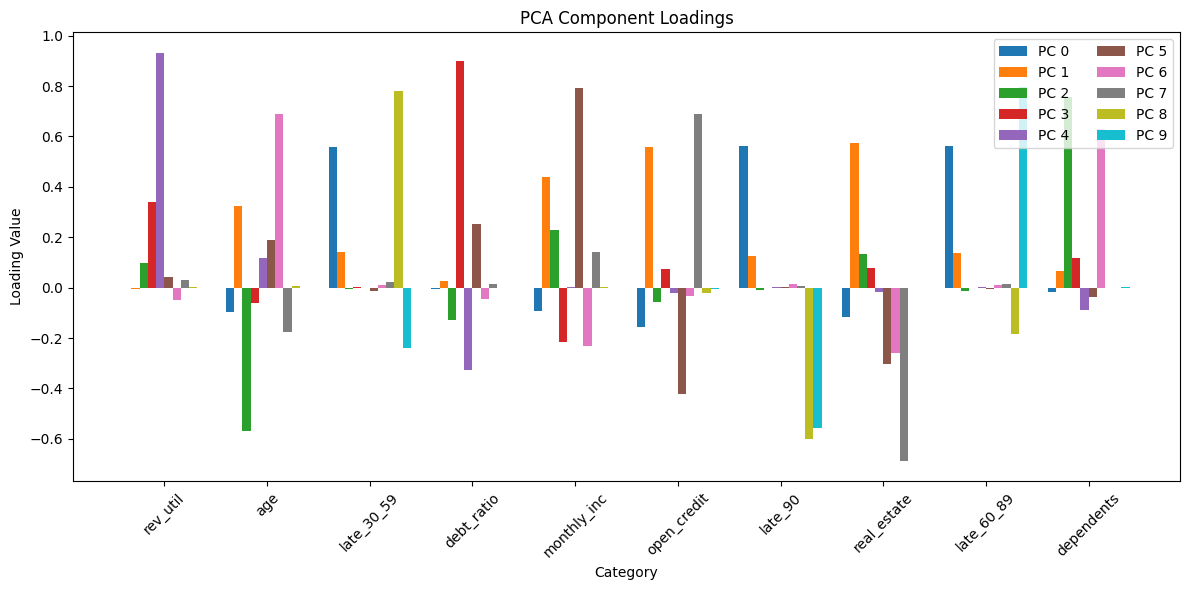

In [317]:
components = pca.components_

plt.figure(figsize=(12, 6))

n_components = pca.n_components_
indices = np.arange(len(X.columns))
bar_width = 0.8 / n_components 

for idx in range(n_components):
    plt.bar(
        indices + idx * bar_width,
        components[idx],
        width=bar_width,
        label=f"PC {idx}"
    )

plt.xticks(
    ticks=indices + bar_width * (n_components-1) / 2,
    labels=X.columns,
    rotation=45
)

plt.xlabel("Category")
plt.ylabel("Loading Value")
plt.title("PCA Component Loadings")
plt.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'MDI Feature Importances for Credit Delinquency')

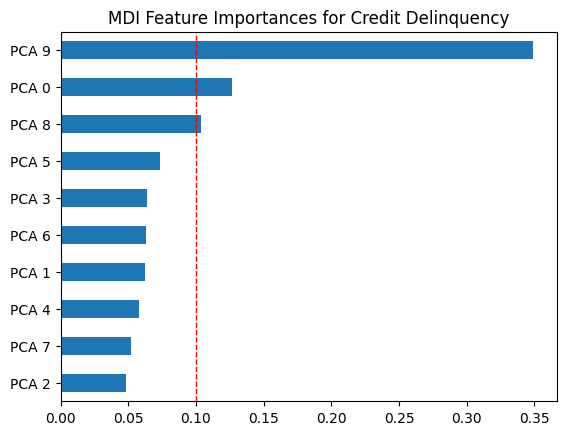

In [318]:
# MDI feature importance
mdi_importances = pd.Series(clf.feature_importances_, index=X_train_PCA.columns)
mdi_importances = mdi_importances.sort_values()
ax = mdi_importances.plot.barh()
ax.axvline(x=0.1, color='red', linestyle='--', linewidth=1)
ax.set_title("MDI Feature Importances for Credit Delinquency")

Text(0.5, 1.0, 'Permutation Importances for Credit Delinquency (OOS)')

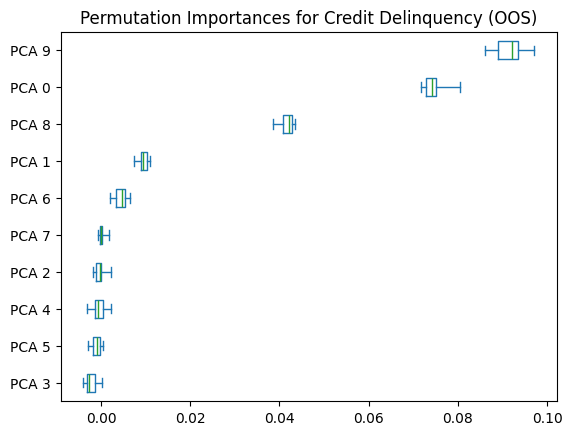

In [323]:
# Permutation Feature Importance (MDA)
pi_result = permutation_importance(clf, X_test_PCA, y_test, n_repeats=10, n_jobs=5)
pi_result_sorted_indices = pi_result.importances_mean.argsort()

pi_importances = pd.DataFrame(data=pi_result.importances[pi_result_sorted_indices].T, 
                              columns=X_test_PCA.columns[pi_result_sorted_indices])


ax = pi_importances.plot.box(vert=False, whis=[0, 100])
ax.set_title("Permutation Importances for Credit Delinquency (OOS)")

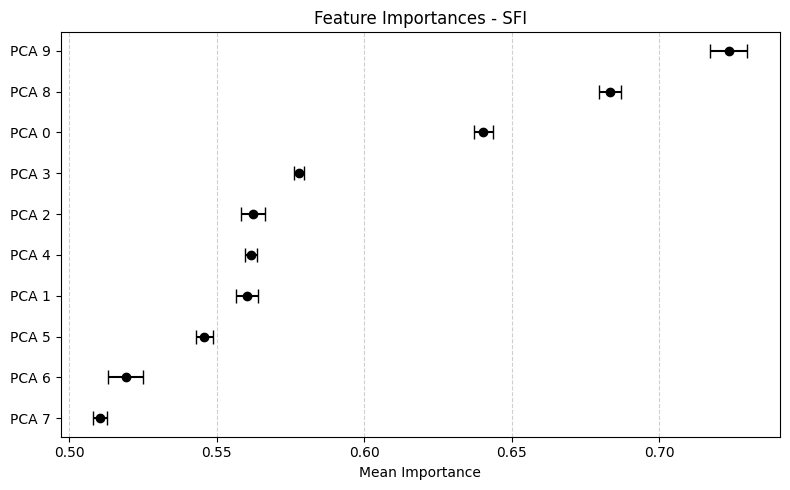

In [324]:
clf2 = RandomForestClassifier(criterion="entropy", max_depth=10, n_estimators=100, max_features=0.7)

sfi_results = simple_sfi(X_test_PCA.columns, clf2, X_test_PCA, y_test, 5, sample_weight=None)

y_pos = np.arange(len(X_test_PCA.columns))
plt.figure(figsize=(8, 5))
plt.errorbar(sfi_results["mean"].iloc[::-1], y_pos, xerr=sfi_results["std error"].iloc[::-1], fmt='o', capsize=5, color="black") 

plt.yticks(y_pos, sfi_results.iloc[::-1].index)
plt.xlabel('Mean Importance')
plt.title('Feature Importances - SFI')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show() 

All three methods agree that the most important features are PCA 0 and PCA 1. In general, substitution effects will dilute feature importances for MDI and underestimate importances for MDA. This is mitigated by orthogonalizing the features beforehand, which accomplished by the PCA.

### 8.2

From exercise 1, generate a new dataset (Ẍ , y), where Ẍ is a feature union of X
and Ẋ .
(a) Compute MDI, MDA, and SFI feature importance on (Ẍ , y), where the base
estimator is RF.
(b) Do the three methods agree on the important features? Why?

In [325]:
pca = PCA()
pca.fit(X_train)

clf = RandomForestClassifier(criterion="entropy", max_depth=10, n_estimators=100, max_features=0.7)

X_train_combined = pd.concat([X_train, X_train_PCA], axis=1)
X_test_combined = pd.concat([X_test, X_test_PCA], axis=1)
X_combined = pd.concat([X, X_PCA], axis=1)

fit = clf.fit(X_train_combined, y_train)

Text(0.5, 1.0, 'MDI Feature Importances for Credit Delinquency')

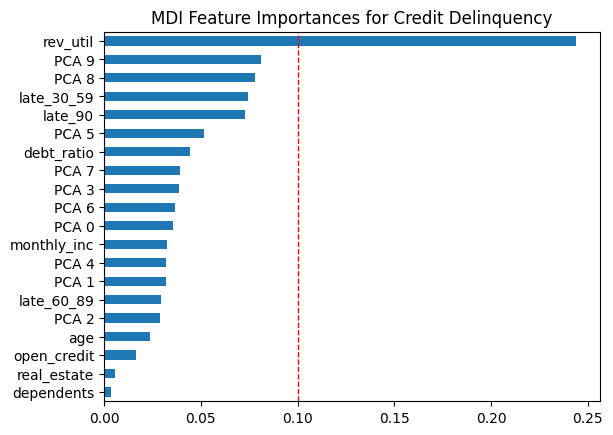

In [329]:
# MDI feature importance
mdi_importances = pd.Series(clf.feature_importances_, index=X_train_combined.columns)
mdi_importances = mdi_importances.sort_values()
ax = mdi_importances.plot.barh()
ax.axvline(x=0.1, color='red', linestyle='--', linewidth=1)
ax.set_title("MDI Feature Importances for Credit Delinquency")

Text(0.5, 1.0, 'Permutation Importances for Credit Delinquency (OOS)')

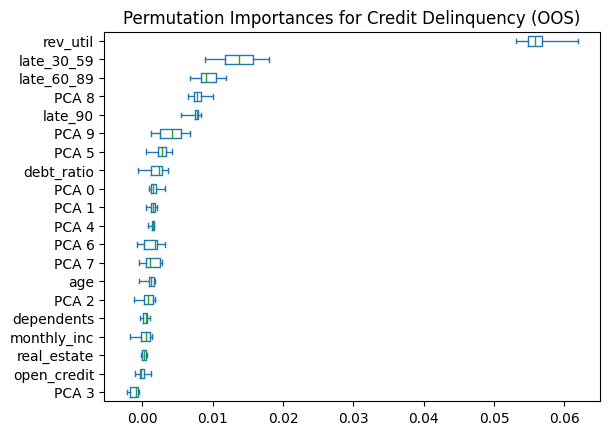

In [327]:
# Permutation Feature Importance (MDA)
pi_result = permutation_importance(clf, X_test_combined, y_test, n_repeats=10, n_jobs=5)
pi_result_sorted_indices = pi_result.importances_mean.argsort()

pi_importances = pd.DataFrame(data=pi_result.importances[pi_result_sorted_indices].T, 
                              columns=X_test_combined.columns[pi_result_sorted_indices])

ax = pi_importances.plot.box(vert=False, whis=[0, 100])
ax.set_title("Permutation Importances for Credit Delinquency (OOS)")

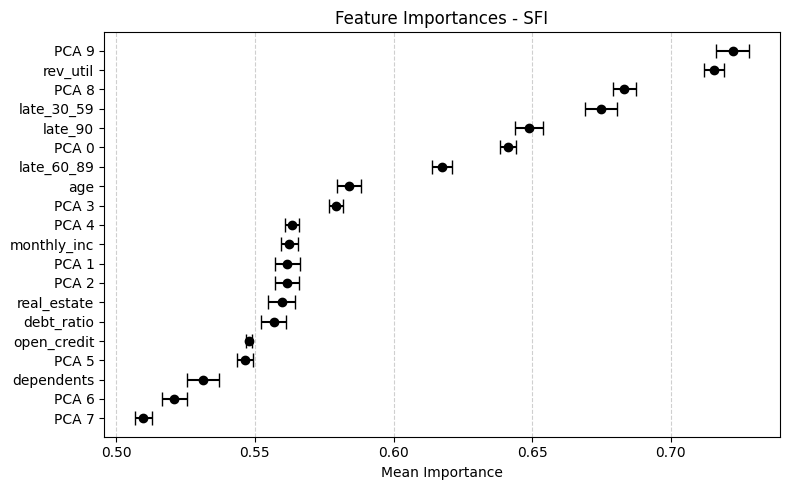

In [332]:
clf2 = RandomForestClassifier(criterion="entropy", max_depth=10, n_estimators=100, max_features=0.7)

sfi_results = simple_sfi(X_test_combined.columns, clf2, X_test_combined, y_test, 5, sample_weight=None)

y_pos = np.arange(len(X_test_combined.columns))
plt.figure(figsize=(8, 5))
plt.errorbar(sfi_results["mean"].iloc[::-1], y_pos, xerr=sfi_results["std error"].iloc[::-1], fmt='o', capsize=5, color="black") 

plt.yticks(y_pos, sfi_results.iloc[::-1].index)
plt.xlabel('Mean Importance')
plt.title('Feature Importances - SFI')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show() 

For MDI and MDA, the methods do not agree on the rankings of the importance of the features. They also don't agree with the ordering from the prior exercise, when restricting to the PCA features.  This is because we have introduced non-orthogonalities, so there are significiant substitution effects. Specifically, we can see that while we found two important features in the first trial, here we only find one--the linear substitution effects have diluted away the others.

On the other hand, the results for SFI exactly match the prior exercise when restricting to the PCA features. This makes sense, as SFI considers one feature at a time and thus feature importances are not diluted due to substitution effects